## **Trying to Implement dcGAN using PyTorch**: _Pokemon Dataset_
---

In [1]:
## Imports 
import matplotlib.pyplot as plt 
from PIL import Image, ImageFile
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as vutils
import glob
import os 
import torch
import torch.nn as nn
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

So before we dive into the DCGAN pipeline, lets first create a suitable dataset path and since we're not going to generate in classified way, we will first load all the images and normalize them before processing 

In [3]:
pokemon_data_path = "/kaggle/input/pokemonclassification/PokemonData"

image_files = glob.glob(os.path.join(pokemon_data_path, "*", "*.*"))

print(f"Total images found: {len(image_files)}")

Total images found: 6837


In [4]:
#@ Preprocessing the data:

### Normalizing the RGB data after resizing them
transform = transforms.Compose([
    transforms.Resize((64,64)), 
    transforms.ToTensor(), 
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]) 
])

### The custom class for Pokemon images:
class PokemonDataset(Dataset):
    def __init__(self, image_files, transform= None):
        self.image_files = image_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

## Creating the dataset and DataLoader:
pokemon_dataset = PokemonDataset(image_files, transform= transform)
dataloader = DataLoader(pokemon_dataset, batch_size= 128, shuffle= True)

In [5]:
##@ Checking the sample
data_iter = iter(dataloader)
images= next(data_iter)
print(f"Batch shape: {images.shape}")

Batch shape: torch.Size([128, 3, 64, 64])


- Batch_size= 128
- Number_of_channels= 3
- height = 64
- width= 64

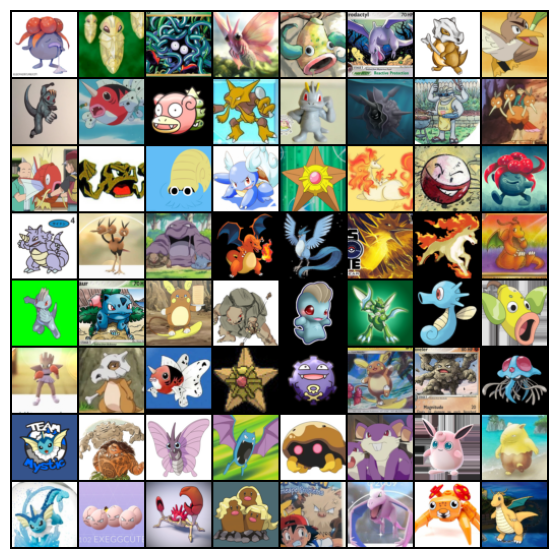

In [6]:
##@ Lets as well as visualize the images loaded

grid = vutils.make_grid(images[:64], nrow= 8, normalize= True)
plt.figure(figsize=(7,7))
plt.imshow(grid.permute(1,2,0))
plt.axis("off")
plt.show()

#### 1. Creating the Generator

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img